In [1]:
import symforce
symforce.set_epsilon_to_symbol()

import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import vo
# pose_metrics requires evo (see top of pose_metrics.py for install instructions)
import pose_metrics
import utils

# Note: this notebook requires pandas in addition to all of Prof. Bretl's dependencies
import pandas as pd

### Provide settings

In [2]:
# When matching (max threshold for ratio test)
matching_threshold = 0.1 # I recommend 0.1 for KITTI and 0.5 for EuRoC

# When deciding if triangulated points are invalid
max_reprojection_err = 0.75

# Temporary folder for evo metrics
temporary_folder = Path('./temp')
temporary_folder.mkdir(parents=True, exist_ok=True)

### Read data

In [ ]:
# RUN THIS CELL FOR MAV

# MAV video folder
mav_video_folder = Path('./data/mav0')

# Read MAV data
dataset_info = utils.read_data_mav(mav_video_folder)
print("Read dataset with keys: {}".format(sorted(list(dataset_info.keys()))))

# Extract relevant data
cam0_K = dataset_info['cam0_K']
cam0_distortion = dataset_info['cam0_distortion']
visual_inertial_data = dataset_info['visual_inertial_data']

In [3]:
# RUN THIS CELL FOR KITTI
kitti_base_path = './data/kitti'
kitti_date = '2011_09_26'
kitti_drive = '0022'

# Read KITTI data
dataset_info = utils.read_data_kitti('./data/kitti', '2011_09_26', '0022')

# Extract relevant data
cam0_K = dataset_info['cam0_K']
cam0_distortion = dataset_info['cam0_distortion']
visual_inertial_data = dataset_info['visual_inertial_data']

### Create random generator

In [4]:
rng = utils.create_rng(None)

seeding RNG with 318691141


### Create image keypoint feature extractor

In [5]:
feature_extractor = cv2.SIFT_create() # could also do ORB_create() for ORB features

### Two view reconstruction

Get initial solution

In [6]:
chosen_index = 0
advance = 5

# Get first index closest to chosen index
first_frame_idx = utils.get_index_of_next_image(visual_inertial_data, chosen_index)
# Get second index
second_frame_idx = utils.get_index_of_next_image(visual_inertial_data, first_frame_idx+advance)

# Create two views
views = [
    vo.create_view_data(utils.read_image(visual_inertial_data[first_frame_idx]['image_file']),
                        first_frame_idx, feature_extractor, cam0_K, cam0_distortion),
    vo.create_view_data(utils.read_image(visual_inertial_data[second_frame_idx]['image_file']),
                        second_frame_idx, feature_extractor, cam0_K, cam0_distortion)
]

# Perform two-view reconstruction
tracks = vo.vo_2view(views, matching_threshold, cam0_K, rng, use_opencv=False)

found 70 good matches
found 70 inliers



REPROJECTION ERRORS
 Image  0 (   70 points) : (mean, std, max, min) = (  0.09,   0.45,   3.83,   0.00)
 Image (raw reprojection)  0 (   70 points) : (mean, std, max, min) = (  0.09,   0.45,   3.83,   0.00)
 Image  1 (   70 points) : (mean, std, max, min) = (  0.09,   0.42,   3.54,   0.00)
 Image (raw reprojection)  1 (   70 points) : (mean, std, max, min) = (  0.09,   0.42,   3.54,   0.00)


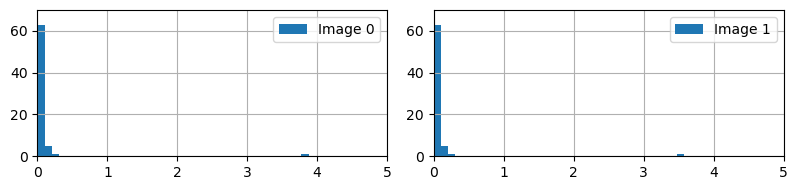

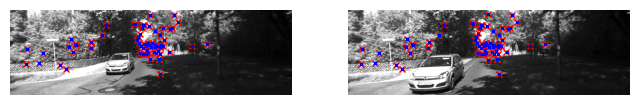

In [7]:
vo.show_reproj_results(views, tracks, cam0_K, cam0_distortion, print_raw_reproj=True, show_reproj_histogram=True)
vo.visualize_predictions(views, tracks, cam0_K, cam0_distortion)

Get post-optimization solution

In [8]:
views, tracks = vo.vo_nonlinear_optimize(views, tracks, cam0_K, max_reprojection_err)

[2024-04-28 20:34:49.289] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 1.221e+01/1.221e+01/1.221e+01, rel reduction: 7.20154e-04, gain ratio: 1.00083e+00
[2024-04-28 20:34:49.306] [info] LM<sym::Optimize> [iter    1] lambda: 1.000e-01, error prev/linear/new: 1.221e+01/1.219e+01/1.219e+01, rel reduction: 8.71686e-04, gain ratio: 1.00164e+00
[2024-04-28 20:34:49.321] [info] LM<sym::Optimize> [iter    2] lambda: 1.000e-02, error prev/linear/new: 1.219e+01/1.219e+01/1.219e+01, rel reduction: 5.43533e-04, gain ratio: 1.00223e+00
[2024-04-28 20:34:49.338] [info] LM<sym::Optimize> [iter    3] lambda: 1.000e-03, error prev/linear/new: 1.219e+01/1.219e+01/1.219e+01, rel reduction: 8.46755e-05, gain ratio: 9.71648e-01
[2024-04-28 20:34:49.338] [info] LM<sym::Optimize> Optimization finished with status: SUCCESS


/Users/andre/mambaforge/envs/ae598-3dv/lib/python3.12/site-packages/symforce/opt/optimizer.py:267: FutureWarning: debug_stats argument is deprecated, use params.debug_stats
  warnings.warn(



REPROJECTION ERRORS
 Image  0 (   67 points) : (mean, std, max, min) = (  0.04,   0.04,   0.18,   0.00)
 Image (raw reprojection)  0 (   67 points) : (mean, std, max, min) = (  0.04,   0.04,   0.18,   0.00)
 Image  1 (   67 points) : (mean, std, max, min) = (  0.04,   0.04,   0.17,   0.00)
 Image (raw reprojection)  1 (   67 points) : (mean, std, max, min) = (  0.04,   0.04,   0.17,   0.00)


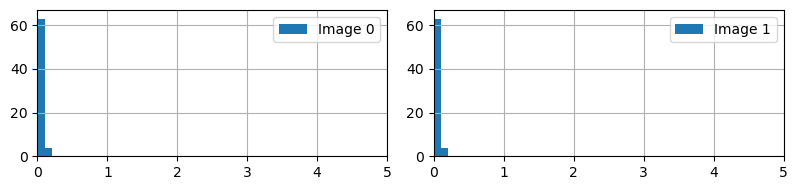

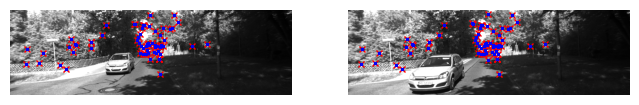

In [9]:
vo.show_reproj_results(views, tracks, cam0_K, cam0_distortion, print_raw_reproj=True, show_reproj_histogram=True)
vo.visualize_predictions(views, tracks, cam0_K, cam0_distortion)

### Compute APE - example
Note, because we only have 2 views we don't have sufficient data to actually do an alignment.

In [10]:
ape_results = pose_metrics.compute_ape(
    pose_metrics.create_tum_data_from_views(times=[visual_inertial_data[view['frame_id']]['time'] for view in views], views=views),
    pose_metrics.create_tum_data_from_groundtruth([visual_inertial_data[view['frame_id']] for view in views]),
    temporary_folder / Path('traj1.txt'),
    temporary_folder / Path('traj2.txt'),
    temporary_folder / Path('results.zip'),
    temporary_folder / Path('results/'),
    align='none', verbose=False, print_results=True,
)


APE EVALUATION (alignment = none)
rmse = 0.633
mean = 0.448
median = 0.448
std = 0.448
min = 0.000
max = 0.896
sse = 0.802


### Compute pose error (with my alignment) example
Basically, we do a coordinate transform so both trajectories start at 0 pose and identity rotation. Then we calculate the error for each time-step. In our case, we probably should just care about the final error elements (which specifies errors between first and last frame).

In [11]:
pose_results = pose_metrics.compute_pose_error(
    pose_metrics.create_tum_data_from_views(times=[visual_inertial_data[view['frame_id']]['time'] for view in views], views=views),
    pose_metrics.create_tum_data_from_groundtruth([visual_inertial_data[view['frame_id']] for view in views]),
    align='posescale', print_results=True,
)

Avg error in translation = 0.448 (min = 0.000, max = 0.895, final = 0.895)
Avg error in rotation = 0.001 (min = 0.000, max = 0.001, final = 0.001)
